In [88]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
import operator
from sklearn.metrics import roc_curve, auc

In [89]:
df=pd.read_csv('Clothing_Store.csv')

In [90]:
df=df.head(7000)

In [91]:
del df['CLUSTYPE']
del df['HHKEY'], df['ZIP_CODE'], df['REC'], df['PC_CALC20'] 
del df['STORELOY']

In [92]:
# df.info()

In [93]:
df['VALPHON']=(df['VALPHON']=='Y')*1

In [94]:
for v in df.columns:
    l=df[v].unique()
    if len(l)<5:
        print v,l

CC_CARD [0 1]
VALPHON [0 1]
WEB [0 1]
RESP [0 1]


In [95]:
df.shape

(7000, 45)

In [96]:
numerical_variable_list=[]
for v in df.columns:
    l=df[v].unique()
    if len(l)>5:
        numerical_variable_list.append(v)
len(numerical_variable_list)

41

In [97]:
categorical_variable_list=[]
for v in df.columns:
    if v!='RESP':
        l=df[v].unique()
        if len(l)<5:
            categorical_variable_list.append(v)
len(categorical_variable_list)

3

#### Look at data

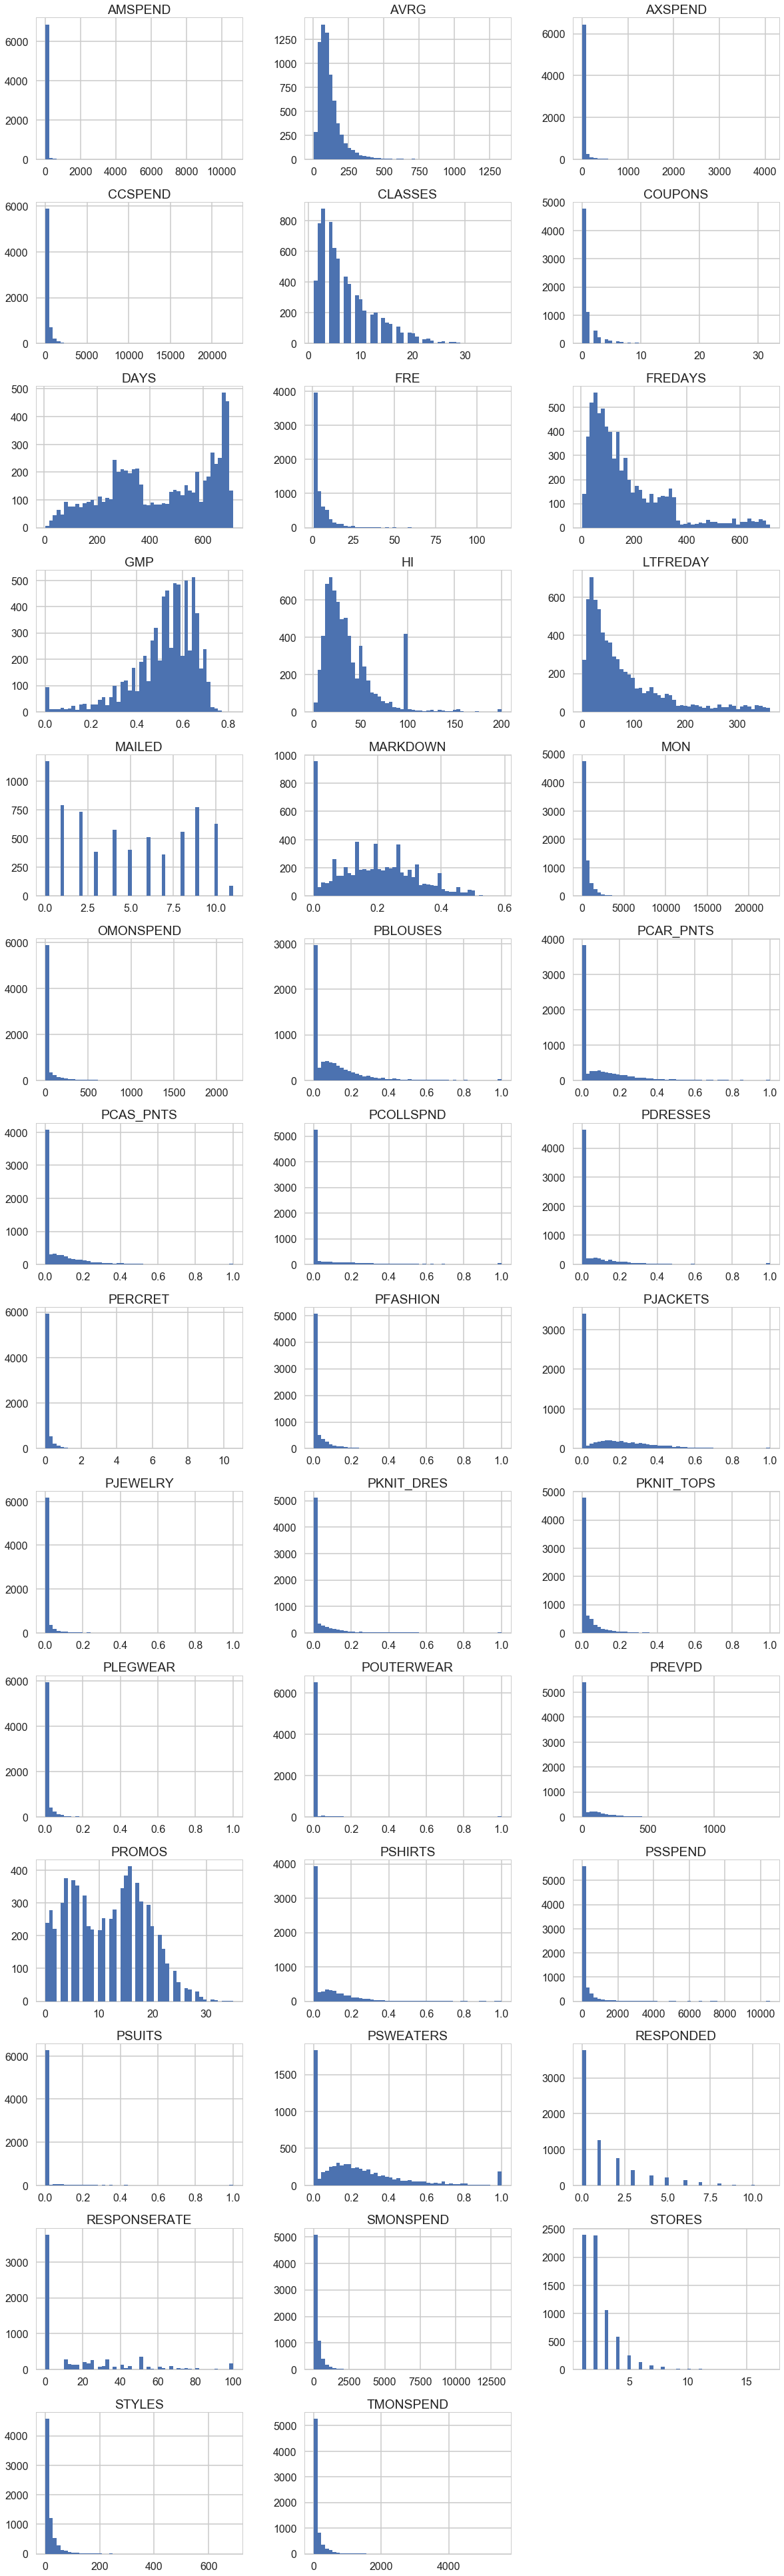

In [49]:
import matplotlib.pyplot as plt
df[numerical_variable_list].hist(bins=50, figsize=(20,70),layout=(14,3))
plt.savefig("numeric_histogram_plots")
plt.show()

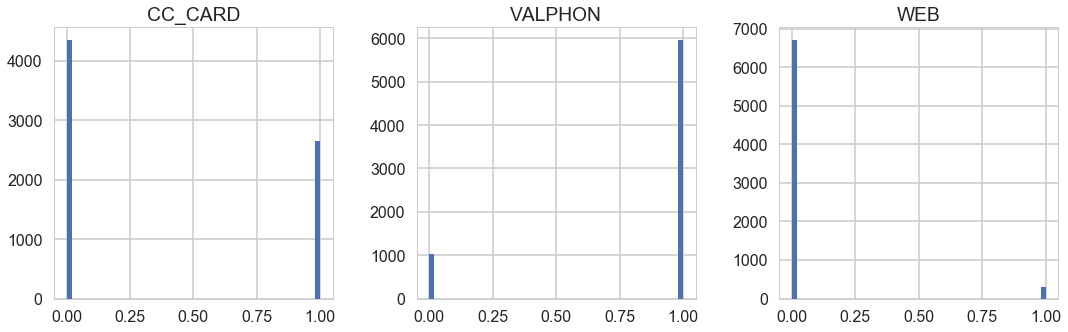

In [50]:
df[categorical_variable_list].hist(bins=50, figsize=(18,5),layout=(1,3))
plt.savefig("categorical_histogram_plots")
plt.show()

#### One finding and one problem
* One problem: Distribution of many variables are right skewed
* One finding: indicator variables might be added to address the importance of absence. columns where the existence or lack thereof of a zero may be important in a classifier. We used our intuition to make these choices, believing that there is additional information encoded in say, PERCRET: if you never returned anything you might not be a budget shopper and thus someone who might have the money to shop quite a bit...
* Adding new variable might be helpful for classification


In [98]:
ZERO_IMPORTANT_VARS = [u'PREVPD', u'AMSPEND', u'PSSPEND', u'CCSPEND', u'AXSPEND', u'RESPONDED', u'PERCRET']

In [99]:
PERCENT_VARS=[ u'PSWEATERS', u'PKNIT_TOPS', u'PKNIT_DRES', u'PBLOUSES', u'PJACKETS', u'PCAR_PNTS', u'PCAS_PNTS', u'PSHIRTS', 
              u'PDRESSES', u'PSUITS', u'POUTERWEAR', u'PJEWELRY', u'PFASHION', u'PLEGWEAR', u'PCOLLSPND']
len(PERCENT_VARS)

15

In [100]:
for p in ZERO_IMPORTANT_VARS:
    df['i_'+p]=(df[p] > 0.0)*1
    categorical_variable_list.append('i_'+p)

In [101]:
for p in PERCENT_VARS:
    df['i_'+p]=(df[p] > 0.0)*1
    categorical_variable_list.append('i_'+p)

In [102]:
#create recent usage (1 month and 3 month),  sale-shopper (markdown+coupon)
df["i_RECENT"]=1*((df.OMONSPEND > 0) | (df.TMONSPEND > 0))
df["i_SAVER"]=1*((df.MARKDOWN > 0) | (df.COUPONS > 0))
categorical_variable_list.append("i_RECENT")
categorical_variable_list.append("i_SAVER")

In [103]:
len(categorical_variable_list),len(numerical_variable_list)

(27, 41)

#### Log transformation and square root transformation for numerical variables to reduce variance. Whole dateset.
* value include zero uses square root
* value not include zeor uses log

In [104]:
numeric_vars_inld_zero=[]
numeric_vars_not_inld_zero=[]
for i,j in dict(df[numerical_variable_list].describe().min()).items():
    if j==0:
        numeric_vars_inld_zero.append(i)
    if j>0:
        numeric_vars_not_inld_zero.append(i)

In [106]:
df_fe=pd.concat([np.log(df[numeric_vars_not_inld_zero]), np.sqrt(df[numeric_vars_inld_zero]),df[categorical_variable_list],
              df['RESP']], axis=1)
df_fe.head()

,STORES,DAYS,HI,LTFREDAY,STYLES,AVRG,FRE,CCSPEND,CLASSES,MON,FREDAYS,PDRESSES,PKNIT_TOPS,PCAS_PNTS,AXSPEND,MAILED,PJEWELRY,RESPONSERATE,PSHIRTS,SMONSPEND,PSWEATERS,RESPONDED,OMONSPEND,AMSPEND,PBLOUSES,PFASHION,COUPONS,MARKDOWN,PREVPD,PCOLLSPND,PSSPEND,GMP,PJACKETS,PKNIT_DRES,PROMOS,PERCRET,POUTERWEAR,TMONSPEND,PCAR_PNTS,PSUITS,PLEGWEAR,CC_CARD,VALPHON,WEB,i_PREVPD,i_AMSPEND,i_PSSPEND,i_CCSPEND,i_AXSPEND,i_RESPONDED,i_PERCRET,i_PSWEATERS,i_PKNIT_TOPS,i_PKNIT_DRES,i_PBLOUSES,i_PJACKETS,i_PCAR_PNTS,i_PCAS_PNTS,i_PSHIRTS,i_PDRESSES,i_PSUITS,i_POUTERWEAR,i_PJEWELRY,i_PFASHION,i_PLEGWEAR,i_PCOLLSPND,i_RECENT,i_SAVER,RESP
0,0.0,6.501290,3.459781,4.709530,2.397895,5.216185,0.693147,5.909332,2.197225,5.909332,5.808142,0.000000,0.000000,0.000000,0.0,2.236068,0.000000,0.000000,0.435890,0.000000,0.424264,0.000000,0.000000,0.0,0.547723,0.141421,1.000000,0.282843,0.000000,0.538516,0.0,0.774597,0.000000,0.000000,4.123106,0.000000,0.0,0.000000,0.500000,0.0,0.173205,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,1,0,1,0
1,0.0,6.545350,3.487987,3.772761,2.639057,4.166665,1.386294,5.552960,1.791759,5.552960,5.159055,0.424264,0.400000,0.374166,0.0,2.000000,0.000000,7.071068,0.000000,16.062378,0.509902,1.414214,7.482647,0.0,0.000000,0.000000,0.000000,0.574456,0.000000,0.608276,0.0,0.734847,0.000000,0.000000,3.741657,0.173205,0.0,11.747340,0.424264,0.0,0.141421,1,1,0,0,0,0,1,0,1,1,1,1,0,0,0,1,1,0,1,0,0,0,0,1,1,1,1,1
2,0.0,5.837730,4.605170,4.228293,0.693147,3.650658,0.693147,4.343805,0.000000,4.343805,5.144583,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.331662,6.244998,0.000000,0.0,0.787401,0.000000,0.000000,3.162278,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.0,6.552508,3.147165,3.294354,3.555348,4.661078,2.079442,6.740590,2.708050,6.740590,4.473009,0.000000,0.000000,0.000000,0.0,3.000000,0.072849,8.165170,0.223607,19.335718,0.616441,2.449490,0.000000,0.0,0.244949,0.173205,1.732051,0.538516,12.893797,0.000000,0.0,0.655744,0.447214,0.223607,4.898979,0.000000,0.0,10.244023,0.412311,0.0,0.100000,1,1,0,1,0,0,1,0,1,0,1,0,1,1,1,1,0,1,0,0,0,1,1,1,0,1,1,0
4,0.0,3.891820,3.350606,3.198673,2.079442,4.470953,0.000000,4.470953,1.386294,4.470953,3.891820,0.000000,0.447214,0.640312,0.0,0.000000,0.412311,0.000000,0.000000,9.350936,0.447214,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.648074,0.000000,0.000000,0.0,0.469042,0.000000,0.000000,0.000000,0.000000,0.0,9.350936,0.000000,0.0,0.000000,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0


Check numerical variables again after transfromation

In [109]:
# df_fe[numerical_variable_list].hist(bins=50, figsize=(20,70),layout=(14,3))
# # plt.savefig("numeric_histogram_plots_after_transform")
# plt.show()

### Test and Training Sets, and Standardization

#### Train Test Split

In [132]:
X=df_fe[categorical_variable_list+numerical_variable_list]
y=df_fe['RESP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [133]:
X_train.shape,X_test.shape

((4900, 68), (2100, 68))

#### Standardization

In [134]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[numerical_variable_list] = scaler.fit_transform(X_train[numerical_variable_list])
X_test[numerical_variable_list]= scaler.fit_transform(X_test[numerical_variable_list])

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [135]:
df_train=X_train 
df_train['RESP']=y_train

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


#### Reletionship between predictors and repsonse variable.

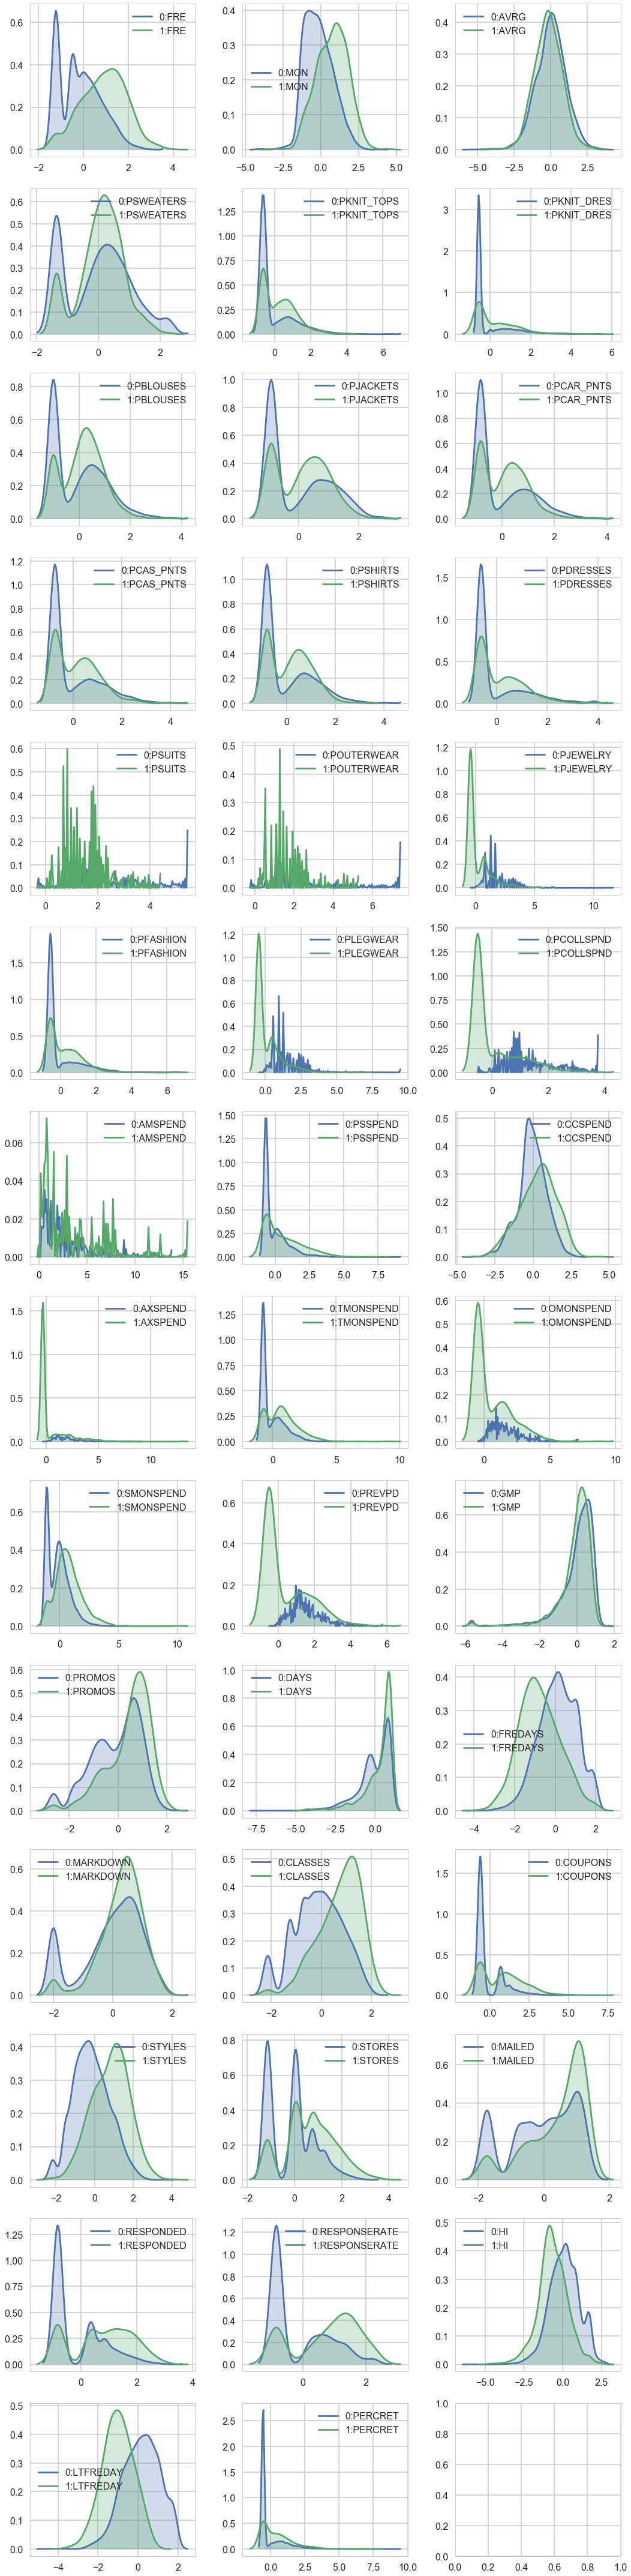

In [124]:
dfgb=df_train.groupby('RESP')
fig, axes = plt.subplots(nrows=14, ncols=3, figsize=(15, 60), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), numerical_variable_list):
    for k, v in dfgb[p]:
        sns.kdeplot(v, ax=ax, label=str(k)+":"+v.name,shade=True)
plt.savefig('Relationships Between the Numeric Predictors and the Response')
plt.show()

In [127]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), 
#                          tight_layout=True)

# for ax, p in zip(axes.ravel(), categorical_variable_list): 
#     table=pd.crosstab(df_train[p],df_train['RESP'])
#     table.div(table.sum(1).astype(float), axis=0).plot(kind='bar',ax=ax,stacked='True')
# plt.savefig('Relationships Between the Categorical Predictors and the Response')
# plt.show()

#### Feature selection

We can also get a notion of which features are important in the classification process by seeing how they correlate with the response. Implement some code to obtain the Pearson correlation coefficient between each of our features and the response. Do this on the training set only! Create a dataframe indexed by the features, which has columns abscorr the absolute value of the correlation and corr the value of the correlation. Sort the dataframe by abscorr, highest first, and show the top 25 features with the highest absolute correlation.

In [136]:
from scipy.stats.stats import pearsonr
correlations=[]
dftousetrain=df_train
for col in dftousetrain[numerical_variable_list+categorical_variable_list].columns.values:
    r=pearsonr(dftousetrain[col].values, df_train['RESP'].values)[0]
    correlations.append(dict(feature=col,corr=r, abscorr=np.abs(r)))

bpdf=pd.DataFrame(correlations).sort('abscorr', ascending=False)
bpdf.set_index(['feature'], inplace=True)
bpdf.head(30)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in absolute
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,abscorr,corr
feature,,
LTFREDAY,0.428306,-0.428306
FRE,0.388324,0.388324
STYLES,0.355294,0.355294
COUPONS,0.329967,0.329967
RESPONDED,0.329562,0.329562
SMONSPEND,0.327217,0.327217
FREDAYS,0.325465,-0.325465
RESPONSERATE,0.322698,0.322698
MON,0.322017,0.322017


In [131]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
estimator = SVR(kernel="linear")
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)
selector.support_ 

selector.ranking_


array([1, 1, 1, 1, 1, 6, 4, 3, 2, 5])

In [137]:
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

In [138]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals